## 

# EI Baseball Analytics 

## Episode 2:  Using Analytics to Understand the Impact of the Shift on MLB Hitters 

### Author: Craig Adams
#### Contact: craig.adams@elementaryinsights.com
#### Date: January 2023

### Table of Contents

[Introduction](#Introduction) <br>
[Methodology](#Methodology) <br>
[Results and Discussion](#Results-and-Discussion) <br>
[Summary and Conclusions](#Summary-and-Conclusions) <br>

###  Introduction

Despite the arguments from baseball traditionalists, Data Analytics has been influencing Major League Baseball (MLB) strategy now for well over 20 years.  The most recognizable example is the [Moneyball](https://www.amazon.com/Moneyball-Art-Winning-Unfair-Game/dp/0393324818/ref=sr_1_1?crid=13OLGXJBO3KWN&keywords=Moneyball&qid=1670887945&s=books&sprefix=moneyball%2Cstripbooks-intl-ship%2C70&sr=1-1) period in Oakland in 2001-2002, as popularized by Brad Pitt in the movie of the same name, where the management emphasized on-base percentage over batting average to find undervalued players to fill out their roster that was under very tight budget constraints.  Another more recent example is the change in hitting strategy known as the  [the Launch Angle revolution](https://www.washingtonpost.com/graphics/sports/mlb-launch-angles-story/) that came to the forefront in 2015-2016, where hitters modified their swing angle to avoid groundballs and hit more homeruns in order to increase both the offensive output of the team and their pay cheques in free agency. 

Another analytics milestone was the use of probabilistic models to reposition defensive fielders to optimum starting positions for each hitter, a strategy that increase the effectiveness and relative value of average defenders. The  so-called 'Shift' was originally deployed in 2010-2012 by the Pittsburgh Pirates, as documented in the book ["Big Data Baseball:  Math, Miracles and the End of a 20-Year Losing Streak"](https://www.amazon.com/Big-Data-Baseball-Miracles-20-Year/dp/1250063507/ref=d_pd_sbs_sccl_2_8/131-2523351-8317501?pd_rd_w=Vc2zS&content-id=amzn1.sym.3676f086-9496-4fd7-8490-77cf7f43f846&pf_rd_p=3676f086-9496-4fd7-8490-77cf7f43f846&pf_rd_r=YMHNY3P9XQ6NEBGCM50K&pd_rd_wg=6bzzN&pd_rd_r=a9af993e-5ab6-4500-9cb8-757d5fe6bb81&pd_rd_i=1250063507&psc=1).  Like all successful analytics strategies, the Shift has been adopted and expanded by nearly every team in baseball, with defensive alterations happening now in both the infield and the outfield on a pitch-by-pitch basis over [one third of the time in 2022.](https://baseballsavant.mlb.com/visuals/team-positioning)

The impact has been so widespread that the MLB owners and MLB union agreed to [ban the Shift](https://www.espn.com/mlb/story/_/id/34556355/major-league-baseball-passes-significant-rules-changes-including-pitch-clock-banning-defensive-shifts) as of the start of the 2023 season, under the perception and possible fact that the Shift is reducing offensive production across the league.  

This off-season, teams are busy rebuilding and preparing for the next season as usual.  The transactions including the signing of free agents and the trading of players from the major league and minor league rosters. Not surprisingly, player value is heavily based on past performance, so a significant rule change could create its own 'Analytics' revolution by increasing the value of certain players over others.  Teams that can project the change in player values may be able to take advantage of the short-term market inefficiencies and capitalize on them by signing or trading for players that are undervalued yet have the chance to out perform next season.

In this exercise, we'll attempt to see if we can find such players.  The specific questions are: 

- Can we confirm that banning the Shift will increase offensive production for the 2023 season?
- Can we project the impact of the Shift ban on hitters prior to the start of the 2023 season? 
- Which players are going to benefit the most?  Which Free Agents might be currently undervalued?


###  Methodology

We will use publically available MLB Statcast pitch-by-pitch and play-by-play data that includes metrics describing the infield and outfield defensive alignments.  The Statcast data can be readily extracted by using the [pybaseball package](https://github.com/jldbc/pybaseball) documented in detail [here](https://github.com/jldbc/pybaseball/tree/master/docs).  

To start, we will look at the seasonal league data and confirm the effects of the Shift on league offense.  We can then move to examine the impacts at the individual player level. 

In [4]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

import pybaseball
from pybaseball import statcast
from pybaseball import playerid_lookup, playerid_reverse_lookup
from pybaseball import statcast_pitcher, statcast_batter
from pybaseball import pitching_stats, pitching_stats_bref

import warnings
import os

import requests
import io

# Set environment
pybaseball.cache.enable()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (8, 6)

In [5]:
# Configuration
file_path = '../data/raw/' 

### Results and Discussion

### Part 1:  Data Processing 

#### Download and Extract Game Data from StatCast

Let's download the pitch-by-pitch data for the last 6 years, configuring each season data pull to the opening day and closing day of the regular season.  Data from playoff games will not be included. Note that the 2021 season was only 60 games instead of the normal 162 game schedules due to COVID-19 restrictions. 

There is a lot of [data that is recorded](https://baseballsavant.mlb.com/csv-docs) for each and every pitch but we will focus only on pitches that turned into events, and on specific details of those events including the batter, the way they stood at the plate (switch hitters can change sides depending on the handedness of the pitcher) and the defensive alignment.  We also want the details of what happened including the physics of each hit when that is the outcome, where the ball was fielded and the metrics that measure the success of the at-bat including the estimated wOBA versus the actual wOBA.  wOBA will be explained in the next section.

Given the length of the data pull (~ 15-20 minutes), we'll both save the individual season data as well as the compiled dataframe to be used as the starting point for this and future analyses. 

In [6]:
# Build dictionaries by manually look up the start and end dates for each season from 2017 to 2022 
start_dates = {2017:'2017-04-02', 2018:'2018-03-29', 2019:'2019-03-20', 2020:'2020-07-01',2021:'2021-04-01', 2022:'2022-04-07'}
end_dates = {2017:'2017-10-01', 2018:'2018-10-01', 2019:'2019-09-20', 2020:'2020-09-27',2021:'2021-10-03', 2022:'2022-10-05'}

# Configure Statcast data pull
columns_to_keep = ['game_year','game_date','batter', 'stand','pitcher', 'p_throws','if_fielding_alignment', 'of_fielding_alignment','bb_type','description','events','des', 'hit_location',
                   'hit_distance_sc', 'launch_speed', 'launch_angle','estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                   'woba_value', 'woba_denom', 'babip_value', 'iso_value','launch_speed_angle']


In [4]:
# Extract and save each season's data
master_df = pd.DataFrame()

for year in start_dates.keys():
    print(f'Processsing {year} statcast data...')

    df_raw = statcast(start_dt=start_dates[year], end_dt=end_dates[year])
    df = df_raw[columns_to_keep]
    df['game_date']= pd.to_datetime(df['game_date'])
    display(df.head(1), df.tail(1))
    master_df = pd.concat([master_df, df])
    
    dir = os.path.join('../data/raw')
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f'Creating new directory: {dir}')
    print(f'Saving file for {year}')
    df.to_csv(file_path+str(year)+'_statcast_events.csv', index=False)

In [5]:
# Save file to disk
master_df.to_csv(file_path+'2017_2022_statcast_event_focus.csv', index=False)

#### Load data from file

In [7]:
# Load and inspect file
master_df = pd.read_csv(file_path+'2017_2022_statcast_event_focus.csv', parse_dates=['game_date'])
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3836151 entries, 0 to 3836150
Data columns (total 23 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   game_year                        int64         
 1   game_date                        datetime64[ns]
 2   batter                           int64         
 3   stand                            object        
 4   pitcher                          int64         
 5   p_throws                         object        
 6   if_fielding_alignment            object        
 7   of_fielding_alignment            object        
 8   bb_type                          object        
 9   description                      object        
 10  events                           object        
 11  des                              object        
 12  hit_location                     float64       
 13  hit_distance_sc                  float64       
 14  launch_speed                     f

In [8]:
print(master_df['game_date'].min(), master_df['game_date'].max())

2017-04-02 00:00:00 2022-10-05 00:00:00


Our raw dataframe contains 23 columns of information about the pitch-by-pitch outcomes with approximately 3.8 million records over the six seasons, starting April 2nd 2017 to October 2nd 2022.

#### Data Cleaning and Feature Engineering

The first step we need to take is to aggregate the data into events. The first five rows show the structure of the pitch-by-pitch data. 

In [9]:
display(master_df.head(5))
# Find unique event count
print(f"Count of event types: {master_df['events'].nunique()}")

,game_year,game_date,batter,stand,pitcher,p_throws,if_fielding_alignment,of_fielding_alignment,bb_type,description,events,des,hit_location,hit_distance_sc,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle
0,2017,2017-10-01,595885,L,532077,R,Infield shift,Strategic,popup,hit_into_play,field_out,Greg Bird pops out to shortstop Richard Urena.,6.0,235.0,81.3,51.0,0.033,0.042,0.0,1.0,0.0,0.0,3.0
1,2017,2017-10-01,595885,L,532077,R,Infield shift,Strategic,NaN,foul,NaN,Greg Bird pops out to shortstop Richard Urena.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017,2017-10-01,595885,L,532077,R,Infield shift,Strategic,NaN,ball,NaN,Greg Bird pops out to shortstop Richard Urena.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017,2017-10-01,595885,L,532077,R,Infield shift,Strategic,NaN,ball,NaN,Greg Bird pops out to shortstop Richard Urena.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017,2017-10-01,595885,L,532077,R,Infield shift,Strategic,NaN,ball,NaN,Greg Bird pops out to shortstop Richard Urena.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Count of event types: 37


 The `des` column documenting the outcome against all pitches for that batter-pitcher interaction.  The `event` column classifies the final outcome into one of 37 categories, and any metrics from a hit ball are included in the columns to the right of the `des` field.

Aggregating the data on the event column seems to be a logical way to achieve what we are looking for, but we will have to assume that there are no bad records in the data where there was a final outcome in the `des` field but a NaN in the associated event column.  We will check the fidelity of the data at the end of this section.

In [10]:
# Filter data for events only
events_df = master_df.dropna(subset=['events']) 
events_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982576 entries, 0 to 3836146
Data columns (total 23 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   game_year                        982576 non-null  int64         
 1   game_date                        982576 non-null  datetime64[ns]
 2   batter                           982576 non-null  int64         
 3   stand                            982576 non-null  object        
 4   pitcher                          982576 non-null  int64         
 5   p_throws                         982576 non-null  object        
 6   if_fielding_alignment            968146 non-null  object        
 7   of_fielding_alignment            968146 non-null  object        
 8   bb_type                          668284 non-null  object        
 9   description                      982576 non-null  object        
 10  events                           982576 non

We have reduced the data from 3.8M to 979K, which suggests that there is normally about 4 pitches per event outcome.  This indeed is the case as shown in the Pit/PA column [here](https://www.baseball-reference.com/leagues/majors/2022-pitches-batting.shtml)

Next, we need to add additional metrics that relate to groupings of the event types that occur at the plate. There 37 possible outcomes of each event at the plate and their relative frequencies for the 2017-2022 seasons are shown in the table below.  
 

In [11]:
def explore_categorical(df, col_name): 
    ''' Plots the counts and displays the frequencies for categorical data in the selected column
    '''
    unique_cat = df[col_name].nunique()
    print(f"Feature '{col_name}' has {unique_cat} unique categories")
    fig_length = [unique_cat/4 if unique_cat/4 > 4 else 4]
    plt.figure(figsize=(10, fig_length[0]))
    df[col_name].value_counts(normalize=True).sort_values(ascending=True).plot(y=col_name, kind='barh', color='steelblue')
#     sns.countplot(y=col_name, data=df, order = df[col_name].value_counts().index, color='steelblue')
    plt.ylabel(f"{col_name}")
    plt.title(f"Frequency of {col_name}")
    plt.show()

    print(df[col_name].value_counts(normalize=True).round(4))

Feature 'events' has 37 unique categories


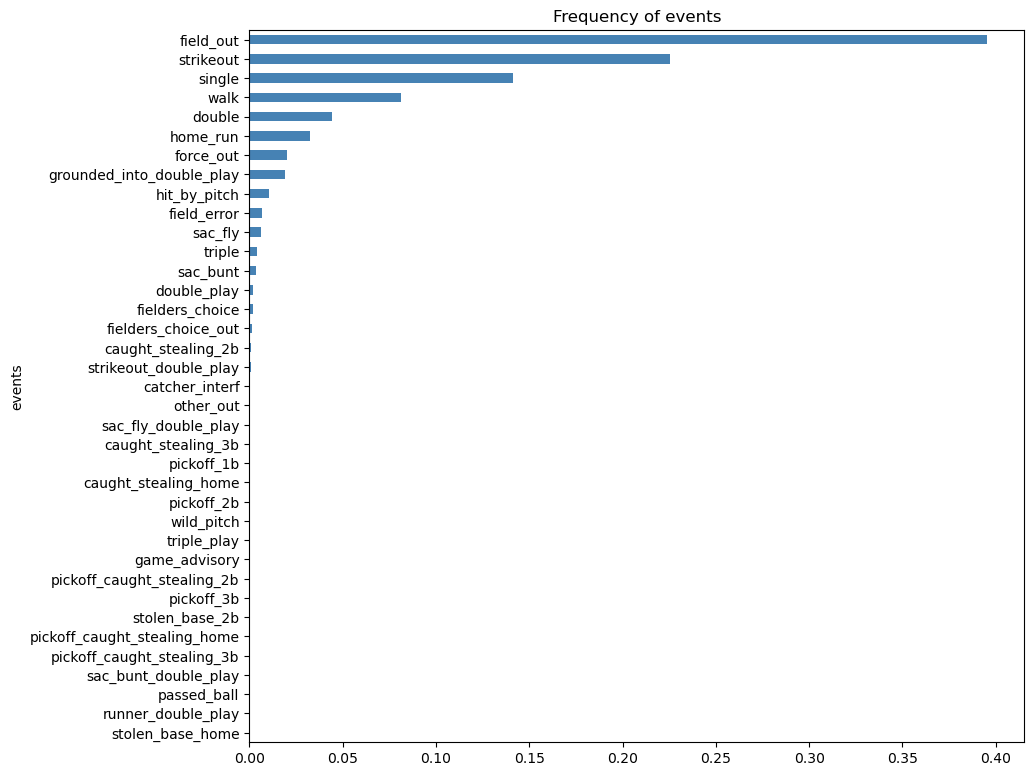

field_out                       0.3955
strikeout                       0.2252
single                          0.1414
walk                            0.0814
double                          0.0445
home_run                        0.0324
force_out                       0.0200
grounded_into_double_play       0.0189
hit_by_pitch                    0.0108
field_error                     0.0070
sac_fly                         0.0063
triple                          0.0041
sac_bunt                        0.0038
double_play                     0.0023
fielders_choice                 0.0021
fielders_choice_out             0.0016
caught_stealing_2b              0.0010
strikeout_double_play           0.0008
catcher_interf                  0.0003
other_out                       0.0002
sac_fly_double_play             0.0001
caught_stealing_3b              0.0001
pickoff_1b                      0.0001
caught_stealing_home            0.0000
pickoff_2b                      0.0000
wild_pitch               

In [12]:
explore_categorical(master_df, 'events')

About 2/3 of the outcomes are field outs or strikeouts, and many events are very rare (e.g. triple plays), but there are many other familiar and frequent events that we can classify to create some traditional MLB statistics.

The first two metrics to add are the counting statistics **At-Bats** and **Plate Appearances**.  The specific definition from MLB are found [here](https://www.mlb.com/glossary/).

**At-bat (AB)**

>Definition: An official at-bat comes when a batter reaches base via a fielder's choice, hit or an error (not including catcher's interference) or when a batter is put out on a non-sacrifice. (Whereas a plate appearance refers to each completed turn batting, regardless of the result.) 

>At-bats are used as the denominator when determining batting average and slugging percentage. Players who bat higher in the order will typically finish the season with more at-bats than players who hit toward the bottom. Similarly, players who walk infrequently also typically record a higher-than-usual number of at-bats in a season, because walks do not count as at-bats.

In [13]:
# Calculate and add AB metric
hits = ['single','double','triple','home_run']
AB = hits+['fielders_choice','fielders_choice_out'] + ['field_error'] + ['strikeout','strikeout_double_play','field_out','force_out', 'double_play', 'triple_play', 'grounded_into_double_play', 'runner_double_play','other_out']

events_df['AB'] = np.where(events_df['events'].isin(AB),1,0)

**Plate Appearance (PA)**

>Definition: A plate appearance refers to a batter's turn at the plate. Each completed turn batting is one plate appearance. Plate appearances can often be confused with at-bats. But unlike with at-bats -- which only occur on certain results -- a plate appearance takes into account every single time a batter comes up and a result between batter and pitcher is obtained.

>Total plate appearances are used to determine which players have qualified for the batting title; at-bats are not used for this purpose, even though at-bats are used to decipher batting average. This rule is in place because not every plate appearance results in an at-bat, and some hitters -- those who walk and are hit by pitches more frequently -- might not qualify for certain statistical leaderboards if only their at-bats were considered.

>The total plate appearances for a team in a game should equal its runs, men left on base and men put out. A batter does not receive a plate appearance if a runner is thrown out on the bases to end the inning while he is at bat, or if the game-winning run scores on a balk, wild pitch or passed ball while he is at bat.

In [14]:
# Calculate and add PA metric
plate_appearance = (AB + ['walk','hit_by_pitch','catcher_interf'] + ['sac_fly','sac_bunt','sac_fly_double_play', 'sac_bunt_double_play'])
events_df['PA'] = np.where(events_df['events'].isin(plate_appearance),1,0)

We will subset our data here to only include plate appearances as the other remaining 1277 events are not related to pitcher-batter interactions (e.g. caught stealing second base).

Feature 'non_PA_events' has 14 unique categories


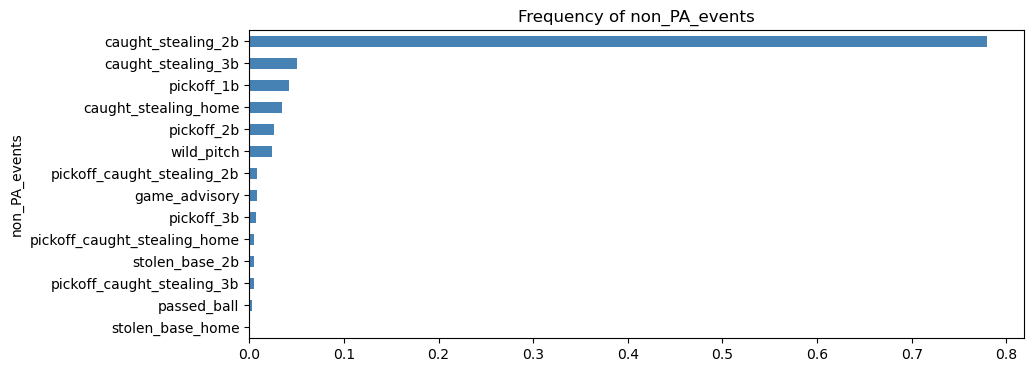

caught_stealing_2b              0.7800
caught_stealing_3b              0.0501
pickoff_1b                      0.0423
caught_stealing_home            0.0345
pickoff_2b                      0.0258
wild_pitch                      0.0235
game_advisory                   0.0086
pickoff_caught_stealing_2b      0.0086
pickoff_3b                      0.0070
stolen_base_2b                  0.0055
pickoff_caught_stealing_home    0.0055
pickoff_caught_stealing_3b      0.0047
passed_ball                     0.0031
stolen_base_home                0.0008
Name: non_PA_events, dtype: float64


In [15]:
# Filter and Inspect non-PA events
non_PA_events = events_df.loc[events_df['PA']==0].rename(columns={'events':'non_PA_events'})
explore_categorical(non_PA_events, 'non_PA_events')

We can also define and add a few other well-known metrics to aid in our analysis.

**On-base Percentage (OBP)**

>Definition: OBP refers to how frequently a batter reaches base per plate appearance. Times on base include hits, walks and hit-by-pitches, but do not include errors, times reached on a fielder's choice or a dropped third strike. (Separately, sacrifice bunts are removed from the equation entirely, because it is rarely a hitter's decision to sacrifice himself, but rather a manager's choice as part of an in-game strategy.)

>A hitter's goal is to avoid making an out, and on-base percentage shows which hitters have accomplished that task the best.

In [16]:
# Calculate and add OBP metric
OBP = hits + ['walk']+ ['walk','hit_by_pitch','catcher_interf']
events_df['OBP'] = np.where(events_df['events'].isin(OBP),1,0)

**Slugging Percentage (SLG)**

> Definition: 
Slugging percentage represents the total number of bases a player records per at-bat. Unlike on-base percentage, slugging percentage deals only with hits and does not include walks and hit-by-pitches in its equation.

> Slugging percentage differs from batting average in that all hits are not valued equally. While batting average is calculated by dividing the total number of hits by the total number of at-bats, the formula for slugging percentage is: (1B + 2Bx2 + 3Bx3 + HRx4)/AB. 

> Although a double is not worth exactly twice as much as a single in the context of scoring runs, slugging percentage is still one of the best evaluators of power, because it accounts for more than just home runs.

We can get ready to calculate SLG by determining the total bases for each type of hit.

In [17]:
# Calculate and add TB metric
total_bases = {'single':1, 'double':2, 'triple':3 ,'home_run':4} # divide by AB
events_df['TB'] = events_df['events'].map(total_bases).fillna(0).astype('int')

Finally, we need to identify the player at the plate.  The current installed pybaseball package has a function that can look up the player IDs and names.  However, as of January 2023, there has been a structural change to the [source database](https://raw.githubusercontent.com/chadwickbureau/register/master/data/) which has broken the file into a series of alpha-numeric coded separate files and rendered the function obsolete.  This requires us to download our own file of names then filter to match those in the seasonal data, taking a queue from the pybaseball function code and the source website's new file structure.

In [18]:
# Config for the new file structure
url = "https://raw.githubusercontent.com/chadwickbureau/register/master/data/"
alpha = ['a','b','c','d','e','f']
file_names = [url+'people-'+str(i)+'.csv' for i in np.arange(0,10)]
file_names = file_names + [url+'people-'+i+'.csv' for i in alpha]
file_names

['https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-0.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-1.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-2.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-3.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-4.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-5.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-6.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-7.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-8.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-9.csv',
 'https://raw.githubusercontent.com/chadwickbureau/register/master/data/people-a.csv',
 'https://raw.githubusercontent.com/chadwic

In [19]:
### Look up all player names and compile them into a file

# players_df = pd.DataFrame()

# for file in file_names:
#     print(f'Reading {file}....')
#     s = requests.get(file).content
    
#     # Subset data to MLB only as per pybaseball
#     mlb_only_cols = ['key_retro', 'key_bbref', 'key_fangraphs', 'mlb_played_first', 'mlb_played_last']
#     cols_to_keep = ['name_last', 'name_first', 'key_mlbam'] + mlb_only_cols
#     table = pd.read_csv(io.StringIO(s.decode('utf-8')), usecols=cols_to_keep)
    
#     # Clean data as per pybaseball
#     table.dropna(how='all', subset=mlb_only_cols, inplace=True)  # Keep only the major league rows
#     table.reset_index(inplace=True, drop=True)
#     table[['key_mlbam', 'key_fangraphs']] = table[['key_mlbam', 'key_fangraphs']].fillna(-1)
#     # originally returned as floats which is wrong
#     table[['key_mlbam', 'key_fangraphs']] = table[['key_mlbam', 'key_fangraphs']].astype(int)
#     # Reorder the columns to the right order
#     table = table[cols_to_keep]
#     print(f"Appending {file}")
#     # Build master file
#     players_df = pd.concat([players_df, table])

In [20]:
# # Save the file for future use
# players_df.to_csv(file_path+'chadwick_bureau_player_names_Jan2023.csv')

In [21]:
players_df = pd.read_csv(file_path+'chadwick_bureau_player_names_Jan2023.csv')

In [22]:
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24399 entries, 0 to 24398
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0.1      24399 non-null  int64  
 1   Unnamed: 0        24399 non-null  int64  
 2   name_last         24399 non-null  object 
 3   name_first        23975 non-null  object 
 4   key_mlbam         24399 non-null  int64  
 5   key_retro         22189 non-null  object 
 6   key_bbref         23034 non-null  object 
 7   key_fangraphs     24399 non-null  int64  
 8   mlb_played_first  22860 non-null  float64
 9   mlb_played_last   22860 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 1.9+ MB


There are over 24K last names in the database with a MLB key for all of the last names.  Next, we build a list of the unique MLB id keys in our data then filter the player names to match.

In [23]:
# Create list of players in the dataset and their mlbid codes
player_ids = list(master_df['batter'].unique())
len(player_ids)

2353

In [24]:
# Build list of matched names
player_names = players_df.loc[players_df['key_mlbam'].isin(player_ids)]
player_names = player_names[['name_last','name_first','key_mlbam']].set_index('key_mlbam')
player_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 594987 to 453385
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name_last   1997 non-null   object
 1   name_first  1997 non-null   object
dtypes: object(2)
memory usage: 46.8+ KB


In [25]:
# Find count of missing names
print(f"Missing names: {len(player_ids) - player_names.shape[0]}")

Missing names: 356


Interestingly we appear to be missing about 350 names from our filtered list vs. the player IDs in our data.  We will go ahead and use the filtered table of names to append the names to our master data then look to see what or who is missing.

In [26]:
# Merge data
df = pd.merge(events_df, player_names, left_on='batter', right_index=True, how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982576 entries, 0 to 3836146
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   game_year                        982576 non-null  int64         
 1   game_date                        982576 non-null  datetime64[ns]
 2   batter                           982576 non-null  int64         
 3   stand                            982576 non-null  object        
 4   pitcher                          982576 non-null  int64         
 5   p_throws                         982576 non-null  object        
 6   if_fielding_alignment            968146 non-null  object        
 7   of_fielding_alignment            968146 non-null  object        
 8   bb_type                          668284 non-null  object        
 9   description                      982576 non-null  object        
 10  events                           982576 non

In [27]:
# Find number of records with missing last names
print(f"Records missing last names: {df['name_last'].isna().sum()}")

Records missing last names: 872


There are still a number of events with missing names.  Fortutiously, almost all (except for one) bad records have a `des` field describing the play so we can fill in the nulls with the first two words of the `des` field


In [28]:
# Find and inspect bad records
bad_records = df.loc[df['name_last'].isna()]
bad_records.head()

,game_year,game_date,batter,stand,pitcher,p_throws,if_fielding_alignment,of_fielding_alignment,bb_type,description,events,des,hit_location,hit_distance_sc,launch_speed,launch_angle,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,AB,PA,OBP,TB,name_last,name_first
2136566,2019,2019-03-26,607486,L,622780,L,NaN,NaN,popup,hit_into_play,field_out,Patrick Cantwell pops out to first baseman Eri...,3.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,1,1,0,0,NaN,NaN
2136588,2019,2019-03-26,605231,L,641409,R,NaN,NaN,ground_ball,hit_into_play,single,Roemon Fields singles on a ground ball to seco...,4.0,NaN,NaN,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,1,1,1,1,NaN,NaN
2136592,2019,2019-03-26,607486,L,641409,R,NaN,NaN,line_drive,hit_into_play,single,Patrick Cantwell singles on a line drive to le...,7.0,NaN,NaN,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,1,1,1,1,NaN,NaN
2136600,2019,2019-03-26,642215,R,596101,R,NaN,NaN,ground_ball,hit_into_play,single,Weston Wilson singles on a ground ball to left...,7.0,NaN,NaN,NaN,NaN,NaN,0.9,NaN,1.0,0.0,NaN,1,1,1,1,NaN,NaN
2136687,2019,2019-03-26,657027,R,665134,R,Infield shift,Standard,fly_ball,hit_into_play,field_out,Nick Tanielu flies out to right fielder JB Shuck.,9.0,254.0,82.6,49.0,0.013,0.012,0.0,NaN,0.0,0.0,3.0,1,1,0,0,NaN,NaN


In [29]:
# Clean remaining records
df['name_last'] = np.where(df['name_last'].isna(),  df['des'].str.split(' ').str[1], df['name_last'])
df['name_first'] = np.where(df['name_first'].isna(),  df['des'].str.split(' ').str[0], df['name_first'])

print(f"Missing last name count: {df['name_last'].isna().sum()} \nMissing first name count: {df['name_first'].isna().sum()}")

Missing last name count: 0 
Missing first name count: 0


We now have the batter first and last name for all events in our data. 



#### Data Validation

One final step remains and that is to check the fidelity of the Statcast data to see if our aggregations of events match the reported seasonal stats.  
 
The selected players are Cavan Biggio of the Toronto Blue Jays, free agents Carlos Santana and Mitch Haniger, sophomore Abraham Toro of the Mariners, and young Yankees rookie Oswaldo Cabrera.

In [30]:
# Validation player list
player_list = [('Biggio', 'Cavan'),
               ('Santana', 'Carlos'),
               ('Haniger', 'Mitch'),
               ('Toro','Abraham'),
               ('Cabrera', 'Oswaldo')
              ]

player_list[0][0]


'Biggio'

In [31]:
# Calculate seasonal stats for validation players
results = []

for i in np.arange(0, len(player_list)):
    player_df = df.loc[(df['name_last']==player_list[i][0])&(df['name_first']==player_list[i][1])]
    player_2022 = player_df.loc[player_df['game_year']==2022]
#     print(f'Events for {player_list[i][1]} {player_list[i][0]}:')
#     display(player_2022['events'].value_counts())
    player_2022.sample()
    player_2022_walks = player_2022['events'].loc[player_2022['events']=='walk'].count()
    player_2022_hits = player_2022['events'].isin(hits).sum()
    player_2022_AB = player_2022['AB'].sum()
    player_2022_PA = player_2022['PA'].sum()
    player_2022_OB = player_2022['OBP'].sum()
    player_2022_TB = player_2022['TB'].sum()
    player_2022_AVG = round(player_2022_hits/player_2022_AB,3)
    player_2022_OBP = round(player_2022_OB/player_2022_PA,3)
    player_2022_SLG = round(player_2022_TB/player_2022_AB,3)

    results.append([player_list[i][1],player_list[i][0], player_2022_hits, player_2022_walks, player_2022_AB,player_2022_PA,player_2022_AVG, player_2022_OBP,player_2022_SLG])

In [32]:
# Print results
results_df = pd.DataFrame(results, columns = ['first_name', 'last_name', 'hits', 'walks','AB','PA', 'AVG', 'OBP', 'SLG'])
results_df

,first_name,last_name,hits,walks,AB,PA,AVG,OBP,SLG
0,Cavan,Biggio,52,38,257,303,0.202,0.317,0.350
1,Carlos,Santana,87,69,431,504,0.202,0.313,0.376
2,Mitch,Haniger,55,19,224,246,0.246,0.305,0.429
3,Abraham,Toro,60,21,324,351,0.185,0.236,0.324
4,Oswaldo,Cabrera,38,15,154,171,0.247,0.310,0.429


Results from comparison of their stats using [Baseball Reference](https://www.baseball-reference.com/players):
- Biggio's stats match except for a single percentage point on OBP which could be a rounding error
- Santana is missing 2 PA that resulted in two walks (OBP of 0.318)
- Haniger and Toro are each missing one PA that resulted in a walk (OBPs of 0.308 and 0.239)
- Cabrera has an OBP 2 points lower than BR has it (0.312) despite no differences in walks (or HBP).

There appears to be a small continuity issue in counting a few of the plate appearances that resulted in walks or equivalent (HBP, catcher interference) and thus OBP metrics.  However, this is not material to the pending analysis of defensive shift frequencies and impacts so we will move ahead with our analysis.


### Part 2: Understanding the Seasonal Trends in the Shift

The first thing we need to do to understand the impact of the Shift rule change is define exactly what a "Shift" is. There are both infield and outfield shifts as defined by MLB:

#### INFIELD POSITIONING

Statcast currently defines infield positioning as one of three categories. 

- Standard (Not Shifted)
- Infield SHIFT: Three (or more) IF on One Side of 2B
- Strategic Shift

>A "strategic" shift is our current catch-all for positioning that is neither "standard," nor "three infielders to one side of second base." More granular categories, like "guarding the lines," "five infielders," etc., may be added in the future.

>Examples of this often include just a single player being out of position, like a second baseman being shifted to short right while no other fielders are, as in the image above, or a shortstop moving very close to the second base bag, outside of the usual shortstop zone, but not quite moving to the other side of it.

The 2017-2022 data shows that the standard shift was deployed about 2/3 of the time, the infield shift about 1/4 of the time and the strategic shift just shy of 1/10th of the time.

From the definition of the new rules, all infielders must start in the infield dirt and on the appropriate side of second base.  So, both the Infield shift and some of the strategic shifts that have a fielder going to the outfield as a rover will be banned for 2023.  For now, though, we can and will only label the Infield shift to be banned Shifts.

Feature 'if_fielding_alignment' has 3 unique categories


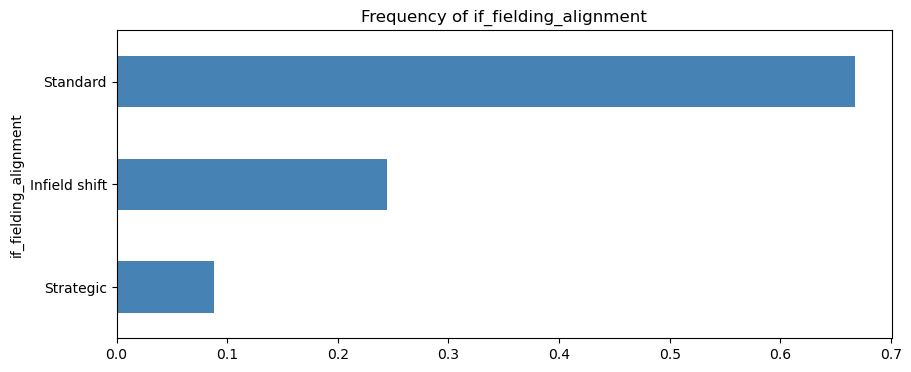

Standard         0.6673
Infield shift    0.2447
Strategic        0.0880
Name: if_fielding_alignment, dtype: float64


In [33]:
# Count and calculate frequencies of IF shifts
explore_categorical(df, 'if_fielding_alignment')

#### OUTFIELD POSITIONING

Statcast currently defines outfield positioning as one of three categories.

- Standard (Not Shifted)
- Strategic Shift Three OF on One Side of 2B** 
- 4th Outfielder** 

Outfield shifts are less prevalent overall, with 92% of plays having normal positioning, 7.7% having strategic shifts and less than 0.1% of the time having 4th outfielders.  The 4th outfielder positioning can only come from having an infielder not start on the dirt, so it can be included in the banned Shifts.

Feature 'of_fielding_alignment' has 3 unique categories


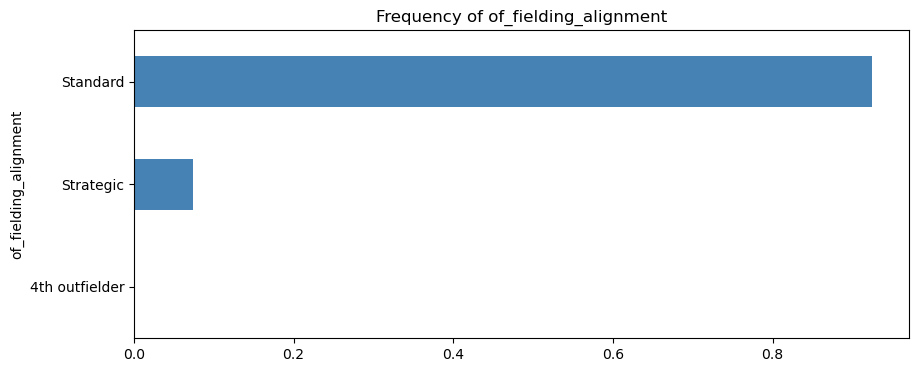

Standard          0.9248
Strategic         0.0740
4th outfielder    0.0012
Name: of_fielding_alignment, dtype: float64


In [34]:
# Count and calculate frequencies of OF shifts
explore_categorical(df, 'of_fielding_alignment')

#### Identifying and understanding banned vs regular defensive shifts

We can create a numeric flag for those events that have the Infield Shift and 4th outfielder defensive positions, then examine the relationships of banned shifts with other variables.

Feature 'banned_shift' has 2 unique categories


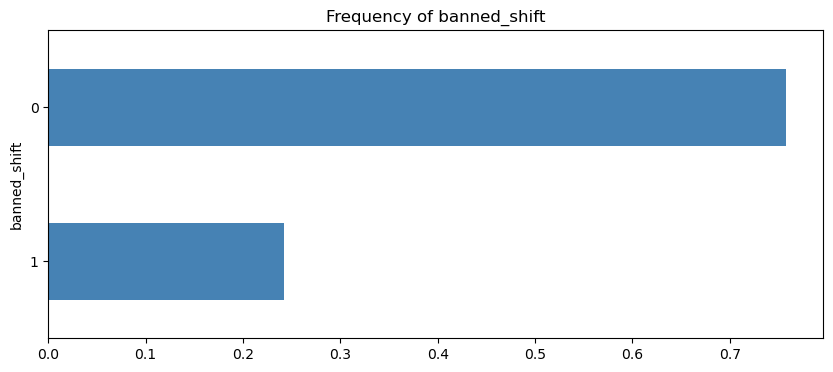

0    0.7581
1    0.2419
Name: banned_shift, dtype: float64


In [35]:
# Separate the data into two sets = shift, no_shift
df['banned_shift'] = np.where((df['if_fielding_alignment']=='Infield shift')|(df['of_fielding_alignment']=='4th outfielder'),1,0)
explore_categorical(df, 'banned_shift')

The banned shift was deployed in 24% of the events in the dataset. The seasonal trends shown in the chart below, show the progression in adaption of the banned shifts over time.

#### Seasonal Frequencies 

In [36]:
# Graph the increase in shifts
def categorical_bivariate(df, column1, column2, sort_tag, colormap='tab20c'):
    """ A function to display the relative frequencies of a binary variable in time    
    """
    pct_df = df.groupby([column1, column2])[column1].count()
#     pct_df.unstack().sort_values(by=sort_tag, ascending=True).plot(kind='barh', stacked=True, 
#                                                                         colormap=colormap, 
#                                                                         title='Absolute Counts', xlabel='')
    
    pct_df_perc = df.groupby([column1, column2])[column1].count()/df.groupby(column1)[column1].count()
    pct_df_perc.unstack().sort_values(by=sort_tag, ascending=True).plot(kind='barh', stacked=True, 
                                                                            colormap=colormap,
                                                                            title=f'Relative Counts for {column2} by {column1}', xlabel='')
    plt.xlabel('Fraction')
#     plt.ylabel({'Season'})
    plt.legend()
    plt.show()
    
    display(pct_df_perc.unstack().sort_values(by=sort_tag, ascending=False).round(3))
#     display(pct_df.unstack().sort_values(by=sort_tag, ascending=False).round(3))

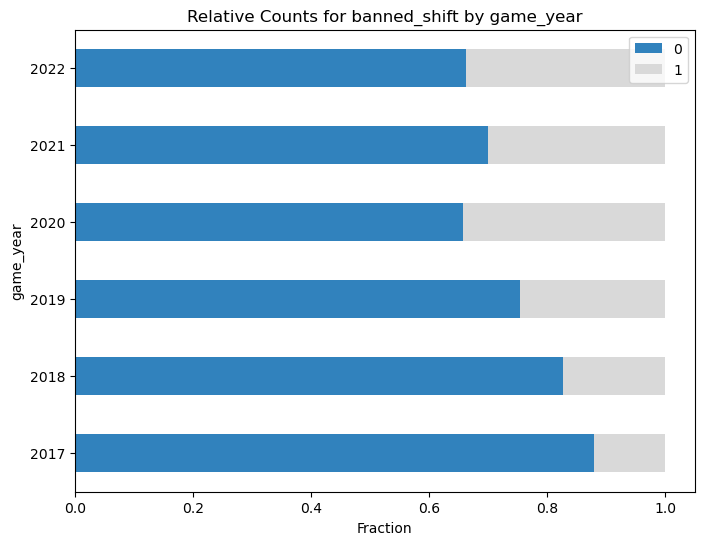

banned_shift,0,1
game_year,,
2022,0.663,0.337
2021,0.699,0.301
2020,0.658,0.342
2019,0.755,0.245
2018,0.827,0.173
2017,0.880,0.120


In [37]:
# Graph the increase in shifts
categorical_bivariate(df, 'game_year', 'banned_shift', sort_tag='game_year')

Clearly the use of banned defensive configurations tripled over 2017 to 2020, from 12% to 30-34% over the past three years.

There is known to be a handedness factor as well.  Hitters with a left-handed (LH) stance represent about 40% of the hitters overall (including switch hitters) and are shifted on more frequently to help throw them out at first base or catch the ball in right-field.

In [38]:
# Calculate frequencies of RH and LH plate appearances
df['stand'].value_counts(normalize=True)

R    0.593018
L    0.406982
Name: stand, dtype: float64

Shifts for LH batters
**************************************************


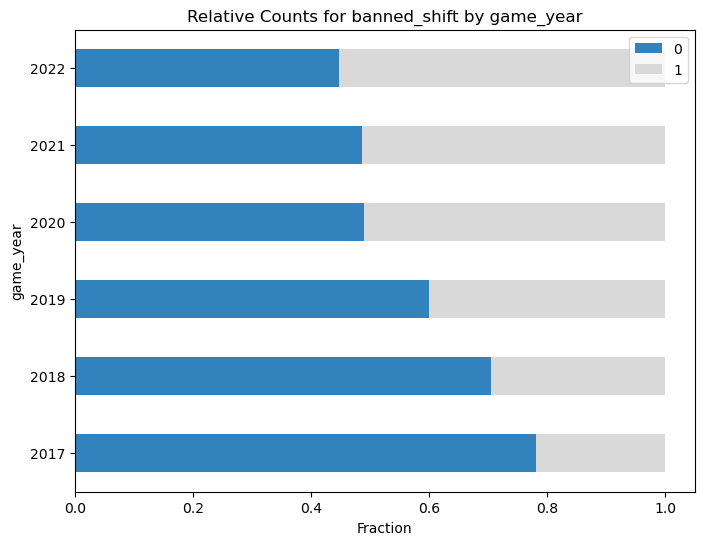

banned_shift,0,1
game_year,,
2022,0.447,0.553
2021,0.487,0.513
2020,0.490,0.510
2019,0.600,0.400
2018,0.705,0.295
2017,0.780,0.220


Shifts for RH batters
**************************************************


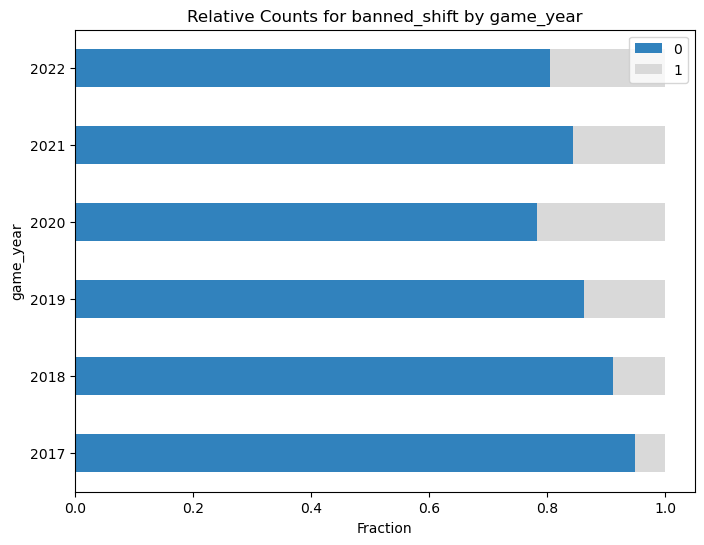

banned_shift,0,1
game_year,,
2022,0.804,0.196
2021,0.843,0.157
2020,0.783,0.217
2019,0.862,0.138
2018,0.912,0.088
2017,0.949,0.051


In [39]:
# Calculate and display shift frequencies for RH and LH plate appearances
batter_handedness = df['stand'].unique()

for stance in batter_handedness:
    print(f'Shifts for {stance}H batters')
    print('*'*50)
    categorical_bivariate(df.loc[df['stand']==stance], 'game_year', 'banned_shift', sort_tag='game_year')

For all seasons from 2017-2022, LH batters have indeed been experiencing banned shifts far more than RH hitters.  In 2022, the average frequency was almost 50% on average in 2022 versus 20% for RHH.  LH batters therefore in theory will benefit the most from banned shifts on average.

### Assessing the Impact of Banning the Shift

Now that we understand the frequency of the banned Shifts, we next need to assess the impact of those banned shifts at a seasonal level: Is there a decrease in offense as reported, particularly for hitters batting from the left side?

Traditionally the way to measure player offense would be to look at the differences in batting average, AVG with and without the shift.  However, we are going to use a more modern metric, wOBA, or **weighted on-base average** which is directly aligned with measuring offense, as defined below. 


**Weighted On-base Average (wOBA)**

> Definition : wOBA is a version of on-base percentage that accounts for how a player reached base -- instead of simply considering whether a player reached base. The value for each method of reaching base is determined by how much that event is worth in relation to projected runs scored (example: a double is worth more than a single).

>For instance: In 2014, a home run was worth 2.101 times on base, while a walk was worth 0.69 times on base. So a player who went 1-for-4 with a home run and a walk would have a wOBA of .558 -- (2.101 + 0.69 / 5 PAs).

> The formula:  Where "factor" indicates the adjusted run expectancy of a batting event in the context of the season as a whole: (unintentional BB factor x unintentional BB + HBP factor x HBP + 1B factor x 1B + 2B factor x 2B + 3B factor x 3B + HR factor x HR)/(AB + unintentional BB + SF + HBP).  Factors are published at the end of each season.

'Unlike on-base percentage and OPS (OBP + SLG), wOBA assigns value to each method of reaching base, in terms of its impact on scoring runs'.

A wOBA metric including in our data for each event with six possible values for probable runs scored from the event. 

Feature 'woba_value' has 6 unique categories


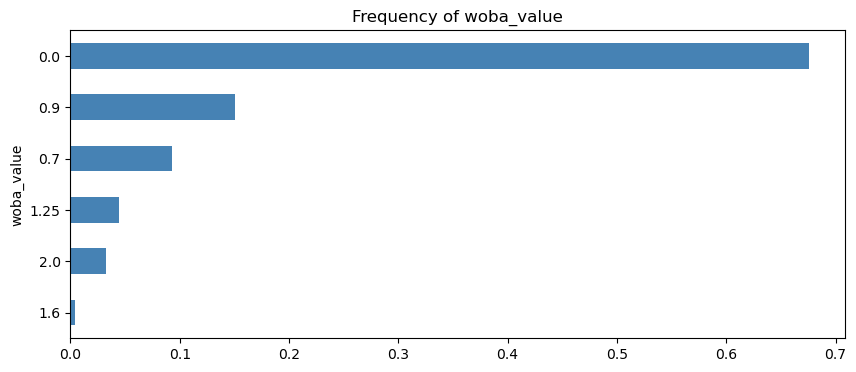

0.00    0.6752
0.90    0.1508
0.70    0.0929
1.25    0.0445
2.00    0.0324
1.60    0.0041
Name: woba_value, dtype: float64


In [40]:
# calculate wOBA event frequencies
# display(df['woba_value'].value_counts(normalize=True))
explore_categorical(df, 'woba_value')

The values are:
- 0.00 for outs, which have happened about 2/3 of the time in our data
- 0.70 for walks and HBP, which occurred at a frequency just shy of 10%
- 0.90 for singles, at 15% of the time
- 1.25 for double and 1.60 for triples, at 4% and 0.4% of the time
- 2.0 for homeruns, which on average are happening 3.2% of all plate appearances

Statcast assigns these generic weights for each type of outcome during the season.  At the end of the season, when all plays and outcomes have been recorded, the actual wOBA weights for each year receive minor adjustments to reflect the true average runs scored.  Each hitter then has a seasonal adjusted wOBA included in their advanced statistics.

For our purposes of season-to-season comparisons, the generic weights are actually more appropriate so we won't apply any post-seasonal adjustments.

The table below shows the mean wOBA for the seasons 2017-2022.  The values tend to be in the range of 0.325 to 0.333, with a high year of 0.337 in 2019 and a low of 0.317 in 2022.

In [41]:
# Calculate mean wOBA values by season
df.groupby('game_year')['woba_value'].mean()


game_year
2017    0.333219
2018    0.324563
2019    0.337237
2020    0.331948
2021    0.325154
2022    0.317084
Name: woba_value, dtype: float64

The seasonal trends in wOBA for banned vs. regular defensive shits is shown below.  The results are a little surprising....

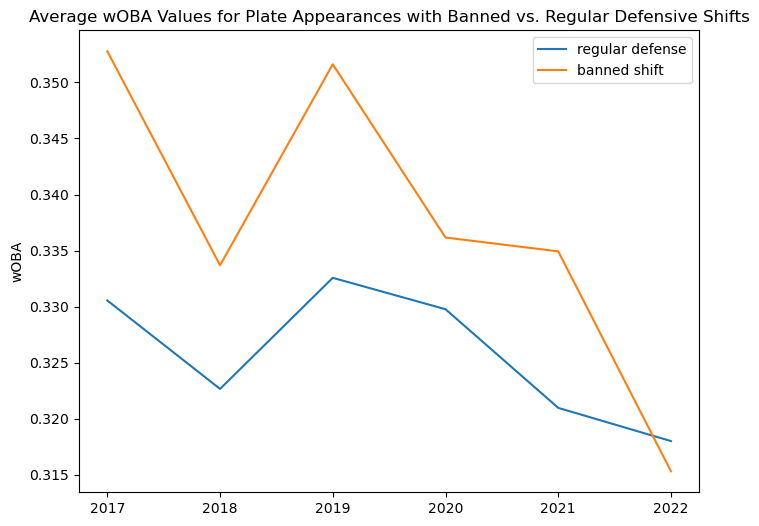

banned_shift         0         1
game_year                       
2017          0.330542  0.352785
2018          0.322649  0.333686
2019          0.332564  0.351620
2020          0.329761  0.336161
2021          0.320955  0.334926
2022          0.317991  0.315296


In [42]:
# Calculate and plot mean wOBA values by season and defensive positioning
woba_df =df.groupby(['game_year','banned_shift'])['woba_value'].mean()
woba_df.unstack().sort_values(by='game_year', ascending=True).rename(columns= {0:'regular defense',1:'banned shift'}).plot(kind='line', stacked=False,
                                                            title='Average wOBA Values for Plate Appearances with Banned vs. Regular Defensive Shifts')
plt.legend()
plt.ylabel('wOBA')
plt.xlabel("")
plt.show()

print(woba_df.unstack().sort_values(by='game_year', ascending=True))

Based on this graph, the average runs scored from banned shift events has been consistently *higher* than from the regular shifts for every year from 2017 to 2021, except for the latest year, 2022. 

This seems to conflict with the narrative that the Shift is causing reduced offense and must be banned, especially since the decision to ban the Shift was made before the start of the 2022 season... Hmmm. Let's take a closer look.

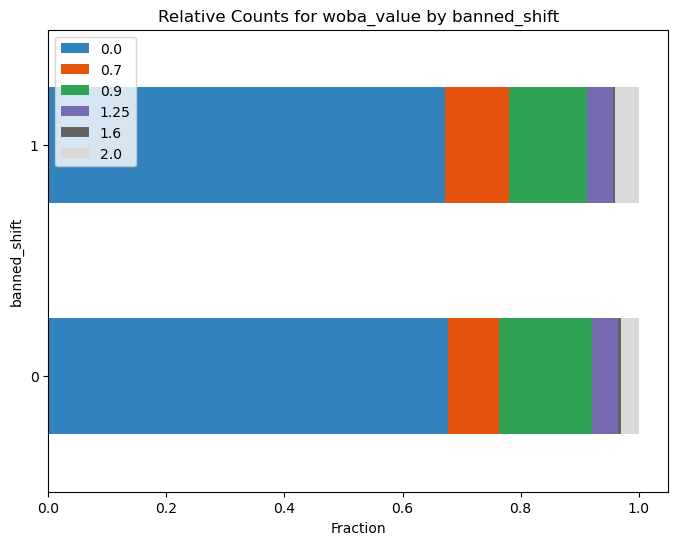

woba_value,0.00,0.70,0.90,1.25,1.60,2.00
banned_shift,,,,,,
1,0.672,0.109,0.132,0.044,0.003,0.04
0,0.676,0.088,0.157,0.045,0.004,0.03


In [43]:
# # Calculate relative frequency of each wOBA type
categorical_bivariate(df, 'banned_shift', 'woba_value', sort_tag= 'banned_shift')

The chart and pivot table show that the frequency of homeruns and walks/HBP-type events is higher for the banned shifts, but lower for the other event types. This pattern makes sense: although the defensive has shifted, they are not (normally) involved in homeruns, walks, HBP or other such events, but do get involved in other hits that can lead to singles, doubles and triples or to outs.  It is also possible that hitters facing the shift will try to hit the ball out of the park instead, with apparently more success than when not shifted on.

The surprisingly high 25% relative increase in homeruns worth 2.00 runs on average may be sufficient to cause the overall wOBA values to be higher for banned shifts for 2017-2022.  Let's check this hypothesis.


In [44]:
# Subset the data into wOBA for HRs vs. non HRs, by season
wOBA_HR = df.loc[df['woba_value']==2.00]
wOBA_exHR = df.loc[df['woba_value']!=2.00]


In [45]:
def calculate_wOBA_composition(shift_flag):
    """
    Generate the metrics for the HR and non HR components of woba by season
    """
    df_wOBA_HR = wOBA_HR.loc[wOBA_HR['banned_shift']==shift_flag].groupby('game_year')['PA','woba_value'].agg({'PA':np.sum,'woba_value':np.mean})
    df_wOBA_exHR = wOBA_exHR.loc[wOBA_exHR['banned_shift']==shift_flag].groupby('game_year')['PA','woba_value','PA'].agg({'PA':np.sum,'woba_value':np.mean})
    df_wOBA = pd.merge(df_wOBA_HR, df_wOBA_exHR, left_index = True, right_index = True, suffixes =['_HR','_excl_HR'])
    df_wOBA['woba_value_from_HR'] = (df_wOBA['PA_HR']*df_wOBA['woba_value_HR'])/(df_wOBA['PA_HR']+df_wOBA['PA_excl_HR'])
    df_wOBA['woba_value_tot'] = ((df_wOBA['woba_value_excl_HR']*df_wOBA['PA_excl_HR'])+(df_wOBA['PA_HR']*df_wOBA['woba_value_HR']))/(df_wOBA['PA_HR']+df_wOBA['PA_excl_HR'])
    
    return df_wOBA

In [46]:
# Calculate metrics
banned_wOBA = calculate_wOBA_composition(shift_flag=1)
reg_wOBA = calculate_wOBA_composition(shift_flag=0)

In [47]:
def plot_stacked_bar(df1, df2, col1, col2, label1, label2):
    ''' Plot stacked bar charts for two separate datasets with common x-axis side by side
    '''
    fig, ax = plt.subplots()
    
    ax.bar(df1.index, df1[col1], align='edge', width=0.2, label =f"{label1} {col1}", color='steelblue')
    ax.bar(df1.index, df1[col2], align='edge', width=0.2, bottom=df1[col1], label =f"{label1} {col2}", color='darkorange')

    ax.bar(df2.index, df2[col1], align='edge', width=-0.2,label =f"{label2} {col1}", color='darkblue')
    ax.bar(df2.index, df2[col2], align='edge', width=-0.2, bottom=df2[col1],label =f"{label2} {col2}", color='darkred')
 
    plt.title("Contribution of Home Runs to the Total wOBA for Regular vs. Banned Shifts")
    plt.ylabel('wOBA')
    plt.legend(loc='lower center')
    plt.show()

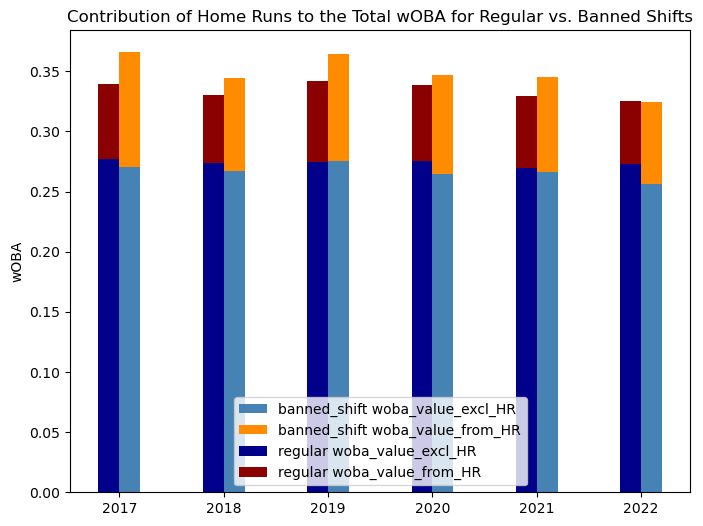

In [48]:
plot_stacked_bar(banned_wOBA, reg_wOBA,  'woba_value_excl_HR', 'woba_value_from_HR', 'banned_shift', 'regular')

In all but the 2022 season, the increase in wOBA for banned vs. regular shifts is indeed the difference in frequency of homeruns.  So, banning the Shift may indeed lead to lower runs scored per game!

#### Rationalizing the Ban 

The analysis of seasonal wOBA contributions also gives us the clue into how to better understand the logic behind banning the Shift: Focus only on the outcomes that ultimately involve the defense handling the ball.  

There is another formal metric that relates to this called BABIP.  

**Batting Average on Balls in Play (BABIP)**

> Definition: BABIP measures a player's batting average exclusively on balls hit into the field of play, removing outcomes not affected by the opposing defense (namely home runs and strikeouts). For example, a hitter who goes 2-for-5 with a home run and a strikeout would have a .333 BABIP. He's 1-for-3 on the balls he put in play.

>The formula: (H - HR)/(AB - K - HR + SF)

Using this formula as a guideline, we can parse through and label our Statcast events as Ball in Play (BAP) events.  

*Side note: The metric `babip_value` is included in our data.  It refers to the specific outcome of a ball in play where 1 = positive result for the hitter (gets on base) and 0 = negative result (out).  Dividing the sum of the `babip_value` by the total BIP events will generate the seasonal BABIP statistic.

In [49]:
# Calculate and add BABIP metric
ball_in_play = ['single','double','triple', 'fielders_choice' ,'fielders_choice_out','field_error','field_out','force_out', 'double_play', 'triple_play','grounded_into_double_play','sac_fly','sac_bunt','sac_fly_double_play', 'sac_bunt_double_play'+'other_out']
df['BIP'] = np.where(df['events'].isin(ball_in_play),1,0)
df['BIP'].value_counts()

1    636433
0    346143
Name: BIP, dtype: int64

Almost 1/3 of the plays with the shift and without the shift ultimately didn't involve the fielders.  

For our impact analysis, we will use the BAP tag to focus in on events that involved the defense, and see whether or not the positioning of the players did influence the wOBA outcomes.

In [50]:
BIP_df = df.loc[df['BIP']==1]

In [51]:
pd.crosstab(BIP_df['banned_shift'], BIP_df['woba_value'], normalize='index')

woba_value,0.00,0.90,1.25,1.60
banned_shift,,,,
0,0.687006,0.238417,0.068094,0.006483
1,0.709300,0.214097,0.071052,0.005551


In [52]:
seasonal_df = BIP_df.groupby(['game_year','banned_shift'])['woba_value'].mean()
seasonal_df = seasonal_df.unstack()
seasonal_df= seasonal_df.reset_index().rename(columns={0:'woba_regular',1:'woba_banned_shift'})

We can calculate from the data, the absolute difference in wOBA between banned and regular shifts


In [53]:
seasonal_df['abs_woba_difference'] = round(seasonal_df['woba_banned_shift']- seasonal_df['woba_regular'],3)
seasonal_df

banned_shift,game_year,woba_regular,woba_banned_shift,abs_woba_difference
0,2017,0.311862,0.289056,-0.023
1,2018,0.309585,0.288428,-0.021
2,2019,0.314617,0.300737,-0.014
3,2020,0.312981,0.287001,-0.026
4,2021,0.305326,0.293035,-0.012
5,2022,0.307013,0.283266,-0.024


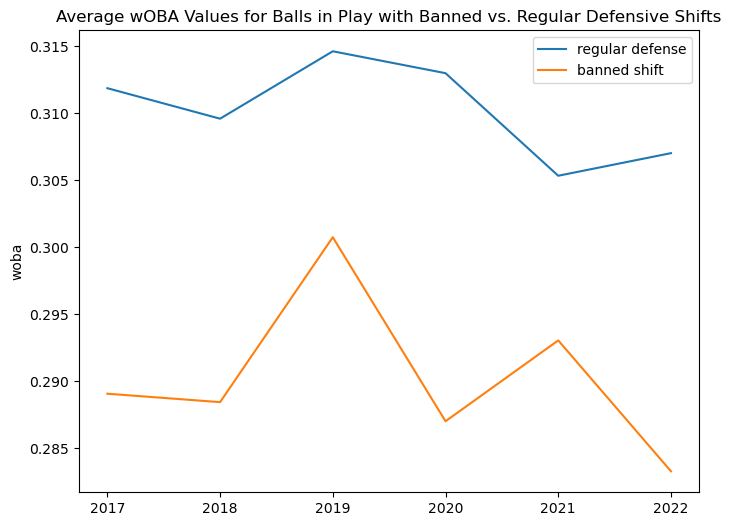

0   -0.023
1   -0.021
2   -0.014
3   -0.026
4   -0.012
5   -0.024
Name: abs_woba_difference, dtype: float64

In [54]:
# Plot results
plt.figure()
sns.lineplot(data=seasonal_df, x='game_year', y='woba_regular', label='regular defense')
sns.lineplot(data=seasonal_df, x='game_year', y='woba_banned_shift', label ='banned shift')
plt.title('Average wOBA Values for Balls in Play with Banned vs. Regular Defensive Shifts')
plt.ylabel('woba')
plt.xlabel("")
plt.show()
display(seasonal_df['abs_woba_difference'])

The Figure shows that the mean wOBA values are generally 11 to 27 points (3-8%) lower than for the banned shifts when the ball is put into play.  The banned shift has indeed been reducing the offense for these types of plays especially in the last year.

We can dig deeper to separate out LH and RH hitters.

In [55]:
# Calculate seasonal stats for LH and RH PA
seasonal_df2 = BIP_df.groupby(['game_year','stand','banned_shift'])['woba_value'].mean()

In [56]:
seasonal_df3 = seasonal_df2.unstack()
seasonal_df3=seasonal_df3.reset_index().rename(columns={0:'woba_regular',1:'woba_banned_shift'})

In [57]:
seasonal_df3['abs_woba_difference'] = round(seasonal_df3['woba_banned_shift']- seasonal_df3['woba_regular'],3)
seasonal_df3

banned_shift,game_year,stand,woba_regular,woba_banned_shift,abs_woba_difference
0,2017,L,0.313342,0.285633,-0.028
1,2017,R,0.310995,0.298615,-0.012
2,2018,L,0.312205,0.283838,-0.028
3,2018,R,0.308148,0.298315,-0.010
4,2019,L,0.320274,0.297818,-0.022
5,2019,R,0.311798,0.306359,-0.005
6,2020,L,0.305917,0.280899,-0.025
7,2020,R,0.316404,0.297345,-0.019
8,2021,L,0.304938,0.289493,-0.015
9,2021,R,0.305482,0.300602,-0.005


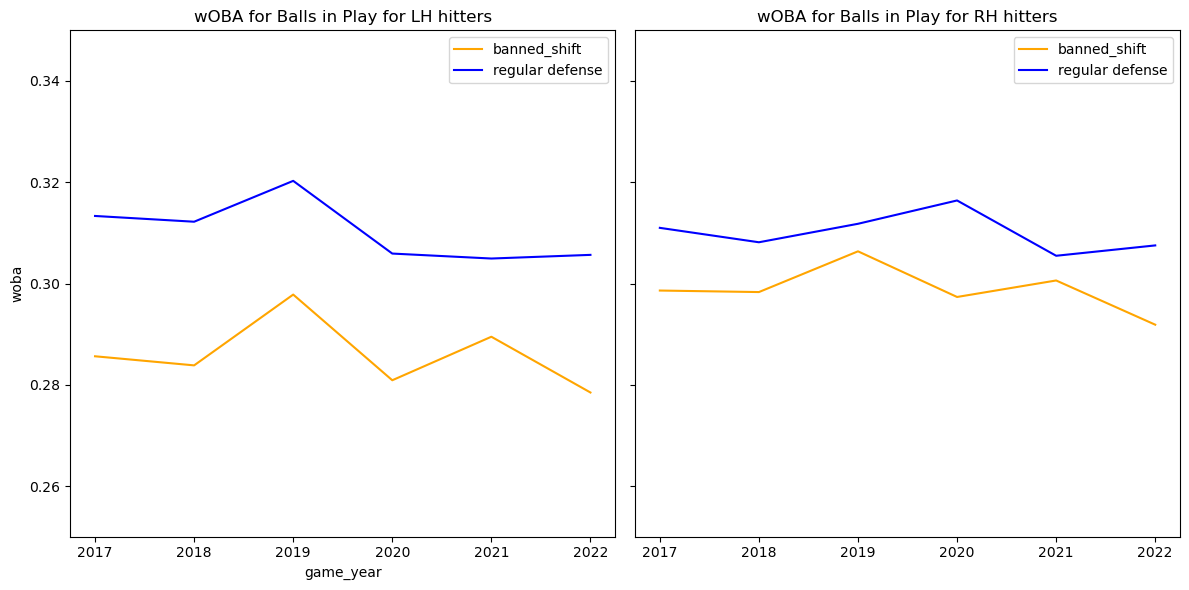

In [58]:
# Plot results
plt.subplots(1,2, figsize=(12,6), sharey=True)
plot_count = 1

for stance in batter_handedness:
    plt.subplot(1,2,plot_count)
    data = seasonal_df3.loc[seasonal_df3['stand']==stance]
    sns.lineplot(data=data, x='game_year', y='woba_banned_shift', label='banned_shift',color='orange')
    sns.lineplot(data=data, x='game_year', y='woba_regular', label='regular defense', color='blue')
    plt.title(f"wOBA for Balls in Play for {stance}H hitters")
    plt.ylim(.250,0.350)
    plt.ylabel('woba')
    plot_count +=1
#     display(stance, data['woba_banned_shift'],data['woba_regular'],data['abs_woba_difference'])

plt.xlabel("")
plt.tight_layout()
plt.show()



This shows that the LHH are indeed taking the brunt, with about a 15-30 point drop vs. 5-15 point drop for RHH for balls hit into play.

One can surmise then that left-handed hitters and switch hitters (who generaly bat LH about 75% of the time) will indeed benefit from the shift ban by almost a 10% increase on average on the runs scored from the events that involve the defense, which on average is about 2/3 of the plate appearances.  

To summarize, the banned shift hasn't in fact reduced the offensive production at large like one would assume.  Instead, the Shift has reduced the runs scored from balls hit into play.  Banning the Shift will therefore not necessarily increase offensive production overall, but instead stimulate runs being scored from plays other than homeruns and free passes.  

Perhaps it is more about recapturing entertainment value for the fans than increasing the runs scored per game.



### Part C: Player Level Impacts

Given that roster construction is now mostly complete, can we find out which players are most likely to benefit from the Banned Shift in 2023?  

We will focus on the 2022 season as the previous season is the most relevant to understanding current and future player performances.  We can calculate their total woba value for banned vs. regular shifts and the differences between them, keeping track of plate appearances for both defensive positionings.  This approache thus includes the effects of HR and walks/HBP on the player wOBA values.

In [59]:
# Filter for 2022 season
player_impact = df.loc[master_df['game_year']==2022]

In [60]:
# Aggregate player data based on PA, shift and wOBA values
player_impact=player_impact.groupby(['name_last','name_first','stand','banned_shift'])['PA','woba_value'].agg({'PA':np.sum,'woba_value':np.mean})
player_impact2 = player_impact.unstack().rename(columns={0:'regular',1:'banned_shift'})

# Add metrics for shift percentage and woba_differences
player_impact2['shift_percent']= round(player_impact2[('PA','banned_shift')]/(player_impact2[('PA','regular')]+player_impact2[('PA','banned_shift')])*100,1)
player_impact2['woba_difference']= round(player_impact2[('woba_value','banned_shift')]-player_impact2[('woba_value','regular')],3)

player_impact2.sample(5)

PA              woba_value               \
banned_shift               regular banned_shift    regular banned_shift   
name_last name_first stand                                                
Jones     Nolan      L        36.0         57.0   0.429167     0.231579   
Young     Jared      L        19.0          3.0   0.336842     0.300000   
Rojas     Miguel     R       498.0          8.0   0.286245     0.225000   
Herrera   Jose       L        44.0         57.0   0.153409     0.228947   
Crawford  J. P.      L       506.0         97.0   0.309350     0.351031   

                           shift_percent woba_difference  
banned_shift                                              
name_last name_first stand                                
Jones     Nolan      L              61.3          -0.198  
Young     Jared      L              13.6          -0.037  
Rojas     Miguel     R               1.6          -0.061  
Herrera   Jose       L              56.4           0.076  
Crawford  J. P.      L              16.1           0.042

We'll set a threshold of 150 PAs to remove bench players and minor leaguers from the analysis, then sort by the shift percentage.

In [61]:
# Subset  ((player_impact2[('PA','banned_shift')]+player_impact2[('PA','no_shift')]>100) & (player_impact2[('PA','no_shift')]>50))]
player_impact3 = player_impact2.loc[ (player_impact2[('PA','banned_shift')] + player_impact2[('PA','regular')]) > 150].sort_values(by='shift_percent', ascending=False)
player_impact3.head(10)

PA              woba_value               \
banned_shift                 regular banned_shift    regular banned_shift   
name_last   name_first stand                                                
Santana     Carlos     L         5.0        357.0   0.580000     0.284497   
Raleigh     Cal        L        10.0        305.0   0.380000     0.336885   
Ramírez     José       L        17.0        477.0   0.517647     0.379036   
Gallo       Joey       L        16.0        394.0   0.265625     0.290228   
Calhoun     Kole       L        22.0        402.0   0.397727     0.253722   
Carpenter   Matt       L         8.0        145.0   0.562500     0.463793   
Seager      Corey      L        34.0        622.0   0.416176     0.326768   
Pasquantino Vinnie     L        18.0        279.0   0.469444     0.368617   
Odor        Rougned    L        32.0        440.0   0.331250     0.279659   
Tucker      Kyle       L        43.0        564.0   0.389535     0.347252   

                             shift_percent woba_difference  
banned_shift                                                
name_last   name_first stand                                
Santana     Carlos     L              98.6          -0.296  
Raleigh     Cal        L              96.8          -0.043  
Ramírez     José       L              96.6          -0.139  
Gallo       Joey       L              96.1           0.025  
Calhoun     Kole       L              94.8          -0.144  
Carpenter   Matt       L              94.8          -0.099  
Seager      Corey      L              94.8          -0.089  
Pasquantino Vinnie     L              93.9          -0.101  
Odor        Rougned    L              93.2          -0.052  
Tucker      Kyle       L              92.9          -0.042

Not surprising, all LH in the top 10 for those shifted against with 100 PAs, max'ing out with Carlos Santana who had banned shifts applied against 98.6% of his LH plate appearances (he is a switch hitter) that resulted in a ball in play.... 

However, what is suprising is the range in woba impact... from a difference of -295 points for Santana to a +25 points for Joey Gallo. 

We can visualize the frequency and impact of the banned shifts in the interactive visual below.


In [62]:
# Flatten table and add fields for plotting
player_impact3=player_impact3.reset_index()
player_impact3['total PA'] = player_impact3[('PA','regular')]+player_impact3[('PA','banned_shift')]
player_impact3['regular wOBA'] = player_impact3[('woba_value','regular')]
player_impact3['banned wOBA'] = player_impact3[('woba_value','banned_shift')]

In [71]:
def plot_wOBA_diff(df, marker_size, save=False):
    
    fig = px.scatter(data_frame=df, x='shift_percent', y='woba_difference', custom_data=['name_first','name_last', 'total PA', 'regular wOBA','banned wOBA'], text='name_last', 
                 color='stand', color_discrete_map={'L':'red', 'R':'blue'}, symbol='stand',symbol_map={'L':'circle', 'R':'diamond'}, size='regular wOBA')
    fig.update_layout(title="The Difference in Banned and Regular Defense wOBA versus Banned Shift Percentage", xaxis_title = 'Banned Shift Percentage', yaxis_title='wOBA Difference (Banned - Regular)', legend_title='Stand')
    fig.update_traces(textposition='bottom center', marker_size=marker_size, hovertemplate ="<br>".join([
                    "name_first: %{customdata[0]}", 
                    "name_last:%{customdata[1]}",
                    "total PA:%{customdata[2]}",
                    "shift_percent: %{x}", 
                    "regular wOBA: %{customdata[3]}",
                    "banned wOBA:%{customdata[4]}",
                    "woba_difference: %{y}"
                        ]) 
                     ) 
    fig.show()
    if save==True:
        fig.write_html('../images/wOBA_differences_banned_vs_regular_defense.html')
    
    return

In [72]:
# Plot wOBA differences
plot_wOBA_diff(player_impact3, marker_size=8, save=True)

The general colour distribution is as expected, with lefties being shifted on (right side red) far more than RHH (left side blue), with the most negative impacts in 2022 being associated with a cluster of LHH with a few RHH.  

The dumb-bell shape to the left and right sides are likely a reflection of small sample size effects.  For example, on the left side, very few RHH were shifted on, so the wOBA difference results are highly sensitive to the outcomes of the banned shift defensive plays.  On the right side, it is the opposite.  There are few non-shifted results, so the wOBA difference becomes sensitive to the outcomes of the few regular shifted outcomes. 

In the middle, the differences appear to be less, but still significant with a skew below the zero line, so that the ranges is about -200 points to plus 100 points.

Let's zoom in and identify those players with shift percentages over 75% and a negative wOBA difference greater than 100 points.

In [73]:
# Focus on high shift percentages with negative Shift impacts
negative_shift_impact = player_impact3.loc[(player_impact3['shift_percent']>=75)&(player_impact3['woba_difference']<=-0.1) ]

plot_wOBA_diff(negative_shift_impact, marker_size=15, save=False)

There are several interesting names and results on this chart.

1. As shown above, Carlos Santana, when batting left-handed was shifted on over 98% of the time, and had a whopping 296 point difference in his wOBA, with his wOBA against banned shifts at 0.285, and his wOBA against regular shift a very large 0.580. This large wOBA difference way higher than the league average of 0.305 for 2022, so it is most likely due to aforementioned small sample size effects on his non-shifted plate appearances, where he only had five PAs.  Interestingly, Carlos Santana just signed a new contract with the Pittsburgh Pirates as a 36 year old, worth 6.75 M.  Hopefully they moderated their expectations of the impact of the Shift accordingly.

2. Fellow switch-hitter Jose Ramirez (total PA 494) has a similar profile with 96.6% shifts (17 regular PAs) and a regular wOBA over .500.  Retired catcher Stephen Vogt and rookie first baseman Vinnie Pasquantino have slight fewer shifts and a lower regular, but still elevated, wOBA of 0.440.  

3. Of the batters with extreme shifts, Kole Calhoun is the only one with regular wOBA below 0.400 for his 22 PAs and thus a banned shift wOBA in the 0.250 range. 

4. In the 80-85% shift percentage range,are switch-hitting free agent outfielder Robbie Grossman and centre fielder Anthony Santander.  In these cases, each has significant PAs against regular shifts, regular wOBA that are not extreme, and thus banned shift wOBAs that are below league average.  As of January 27th, Robbie Grossman is still looking for a job.  He might be someone that the market is undervalueing from an offense point of view.

5. At the top right, we have four other players, two of which are LHH (Abraham Toro, MJ Melendez) and two are RHH (free agent Jorge Soler, and star center fielder Brian Buxton of the Twins).  Buxton has a regular wOBA approaching 0.500, which is very high and skews his wOBA difference, whereas Toro has a split of 0.393 for regular defense vs 0.210 for the shift.  Toro just got traded from the Mariners to the Brewers just two years after being brought by Seattle in a [controversial 2021 trade deadline deal]((https://www.mlbtraderumors.com/2021/07/mariners-trade-kendall-graveman-astros-abraham-toro-joe-smith.html)


In [74]:
# Filter for positive Shift impact
positive_impact = player_impact3.loc[(player_impact3['woba_difference']>0.1) & (player_impact3['shift_percent']>=75)]
plot_wOBA_diff(positive_impact, marker_size=15)

On the other side of the picture, there are four LH hitters that have positive wOBA differences: second basement Max Muncy, outfielder Max Kepler and well-traveled first baseman Lewis Diaz.  The latter two are interesting: 

- Max Kepler has been mentioned repeatedly in trade rumours this off season after a poor year in 2023 in which he did better against the shift than not, but so far no one has made a trade for him.  This might be why.
- As of January 27th, Lewin Diaz has experienced the [following](https://www.mlbtraderumors.com/2023/01/orioles-outright-lewin-diaz.html):

> The Orioles announced that first baseman Lewin Díaz has cleared outright waivers and been outrighted to Triple-A Norfolk. He will stick in the organization but without taking up a roster spot. This move will finally bring some semblance of stability to a wild offseason for Díaz, who recently turned 26. He began the offseason with the Marlins but was designated for assignment in November. He was claimed off waivers by the Pirates but they then designated him a week later. The Orioles claimed him in early December but only kept him on the roster for another three weeks, giving him his third DFA in the span of about a month. He was traded to the Braves for cash, though they gave him his fourth DFA of the winter about a week after that. The Orioles claimed him a second time in early January and then designated him once more last week, though Díaz has finally passed through unclaimed this time. Though Díaz would have probably liked to have held a roster spot, he now at least knows which team’s Spring Training camp he’ll be reporting to next month.

Sounds like teams are interested in him, but after a year in which he only hit 0.169 with a feeble 0.288 SLG while hitting *better* against the Shift, perhaps they are wary of committing a roster spot to someone that may continue to do poorly once the shift is banned.

In [75]:
# Filter for neutral Shift impact
neutral_impact = player_impact3.loc[(player_impact3['shift_percent']>=75)& ((player_impact3['woba_difference']<0.1)&(player_impact3['woba_difference']>-0.1)) ]
plot_wOBA_diff(neutral_impact, marker_size=15)

The middle ground is occupied by many familiar names, mostly LHH with a few RHH

- players that were neutral to the shift last year including RHHs Marcus Semien, Luke Voit and Eugenio Suarez, and LHHs Cavan Biggio Shohei Ohtani, Cody Bellinger, Anthony Rizzo and Joey Gallo.  It is unfortunate for Cody Bellinger as he had a poor year only three years removed from being an MVP candidate.  A larger (and negative) wOBA difference might have led to a better contract in his first year of free agency, instead of the 'show me' one year USD 12.5M deal he received with an option worth USD 25M for the following season if he gets back on track.  Joey Gallo also only managed a modest (for baseball) USD 11M contract this off season after being dumped by the Yankees at the 2023 trade deadline.

- players with upside on the banned shift including Corey Seager who had a middling year in year 1 of his monster USD 325M 10 yr deal for Texas, recently traded first baseman Ji-Man Choi, young Jared Kelenic who is being dubbed as a failed top prospect by fans in Seattle and fellow aging/declining prospect Josh Naylor of the Guardians.

- players with downside and at risk of regression with the shift ban include free-agent Dan Vogelbach who was signed by the Mets to play 1st base (!) albeit for a modest USD 1.5M, recently released Mike Moustakas, recently traded/dumped Jesse Winker who had a rough year in Seattle, free agent Brandon Belt, playoff hero Kyle Schwarber, and off-injured Aaron Hicks of the Yankees.  Perhaps this is why the Yankees are still looking for a new left fielder as spring training approaches.

The range of wOBA differences for players shifted on between 40% and 75% of the time is shown below.

In [76]:
# Focus on moderate shift percentage
mid_range = player_impact3.loc[(player_impact3['shift_percent']<75)& (player_impact3['shift_percent']>=40) ]
plot_wOBA_diff(mid_range, marker_size=15)

Players with the most upside include RHH Mitch Haniger who was not brought back by Seattle and instead signed a USD 43M 3yr contract with the Giants, Jordan Luplow who signed with the Atlanta Braves for USD 1.4M, and Dominic Smith who just got traded by the Mets after a down season.  It looks like their new teams might be in position to benefit from the shift ban for these three players.

Players with the most downside include Jose Altuve, 2022 free agent disappointment Kris Bryant, and recently released Jason Heyward.  Also in the list is Kyle Garlick, who was just designated for assignment by the Minnesota Twins to the surprise of some.  Maybe the Twins have done a similar analysis and would rather bet on the performance of their other outfielders like Nick Gordon next year (but not Max Kepler :)).

Players neutral to the shift include all-star LHH Freddie Freeman of the Braves who did slightly better against the shift (perhaps why the percentage is around 50% only), free agent Josh Bell, unsigned free agent Jurikson Profar and switch-hitting outfielder Bryan Reynolds of the Pirates who wants out of Pittsburgh.  Hopefully teams interested in Profar and Reynolds are not expecting much value from the shift ban in 2023.

In [77]:
# Focus on 2023 Blue Jays
bluejays = {'Biggio':'Cavan', 'Kiermaier': 'Kevin','Varsho':'Daulton','Belt':'Brandon','Bichette':'Bo','Springer':'George','Guerrero':'Vladimir Jr.','Kirk':'ALejandro','Jansen':'Danny','Chapman':'Matt','Espinal':'Santiago'}
jays_impact = player_impact3.loc[player_impact3['name_last'].isin(bluejays.keys())]
plot_wOBA_diff(jays_impact, marker_size=15)

For the most part, the 2023 Jays roster does not look like it will be significantly impacted.  Bo Bichette had exactly one PA against the shift so his low wOBA difference is not significant.  Kirk, Guerrero, Springer, Biggio and newly acquired LHH left fielder Varsho all were neutral to the shift.  Chapman, Jansen and new CF Kevin Kiemaier had small negative wOBA differences suggesting some upside for 2023.  Meanwhile, Espinal and new LHH 'bat-for-hire' Brandon Belt are at risk of regression.  This is a bit concerning for the latter signing as the Jays really do need some quality LHH in their top 5 lineups.  We'll have to hope that the difference for him and for Espinal can be chalked up to small sample sizes against regular and banned defense respectively. 


### Summary and Conclusion

We have learned the following from a league perspective by analysing seasonal data for 2017-2022:
1.  The Shift frequency has been increasing since 2017 with close to 50% of the plate appearances for left hand hitters and 20% of those for RHH having some form of positioning in the infield or outfield that will be banned in 2023.
2.  The banned shifts have not been reducing offense during that time period.  In fact, for 2017 through 2021, the mean weighted on base average or wOBA for the league has been higher for plate appearances with the banned shifts versus those without
3.  The surprising result is due to the ~25% increase in homeruns hit against the Shift, with homeruns counting for 2 runs on average versus less than 1 run on average for balls hit into play where the defense can get involved.
4.  Banning the Shift therefore appears to have more to do with changing the outcomes of Balls in Play, especially for left-handed hitters.

In addition, we have learned the following by analysing the 2022 data from a player perspective:
1.  Small sample sizes skew the measured differences in wOBA between regular and banned shift defenses at the extreme high and low shift percentages
2.  There are several players that did poorly against the shift last year who have thus projected upside for the 2023 season.  Players to watch for bouncebacks from banning the Shift include recently signed FAs Carlos Santana and Mitch Haniger, unsigned Robbie Grossman, recently traded Dominic Smith and Abraham Toro, and young players Jared Kelenic and Josh Naylor
3.  Several players did poorly against regular defense instead of the banned shift including well-traveled Lewin Diaz, on-the-block Max Kepler and maybe-not the LF for the Yankees, Aaron Hicks. Other players to watch in this space are Kyle Schwarber, Kris Bryant and the DFA'd Kyle Garlick
4.  For the Jays, there isn't much expected change except a possible positive change for CF Kevin Kiermaier and a possible regression for Brandon Belt.

Like everything though, past performance is no guarantee of future value.  Player injuries, off-season training and luck all have a strong effect too.  Nevertheless, it will be fun to watch what happens to the players discussed above and the league in general in the upcoming season.  Spring training, bring it on!
